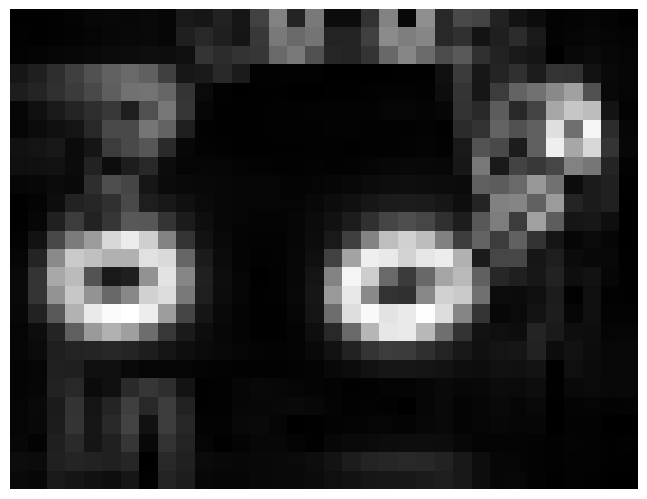

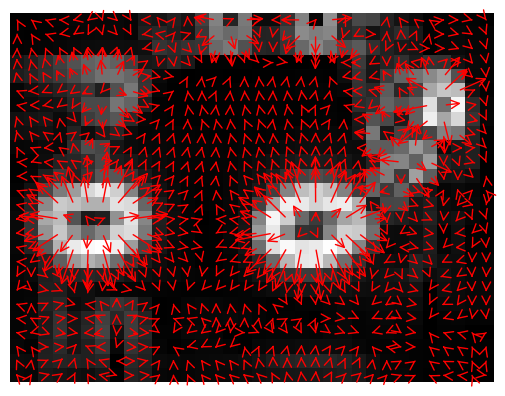

In [2]:
import sys
sys.path.append('../src')

from illustrate import get_image, plot_image
from transform import convert_to_grayscale
from representation import decimate
from filters import Sobel

import matplotlib.pyplot as plt
import numpy as np

test_image_url = 'https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/Vd3bj2jPe/night-traffic-on-autobahn-night-city-road_vkqxllatl_thumbnail-1080_01.png'

image = get_image(test_image_url)
grayscale_image = convert_to_grayscale(image)
cropped_image = grayscale_image[650:780, 300:470]
decimated_image = decimate(cropped_image, factor=5)

image_filter = Sobel()
magnitude, angle = image_filter.apply(decimated_image)
plot_image(magnitude)
_angles = [x if x > 0 else 360 + x for x in angle.flatten()]
_angles = np.reshape(_angles, angle.shape)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(magnitude, cmap='gray')
ax.axis('off')

def draw_arrow(ax, x, y, angle_degrees, length, color='red', arrowstyle='->', mutation_scale=15):
    # Calculate the endpoint of the arrow
    end_x = x + length * np.cos(np.radians(angle_degrees))
    end_y = y + length * np.sin(np.radians(angle_degrees))

    # Draw the arrow
    arrowprops = dict(arrowstyle=arrowstyle, color=color, mutation_scale=mutation_scale)
    ax.annotate('', xy=(end_x, end_y), xytext=(x, y), arrowprops=arrowprops)

for i in range(0, _angles.shape[0]):
    for j in range(0, _angles.shape[1]):
        draw_arrow(ax, j, i, _angles[i][j], magnitude[i][j]/255)


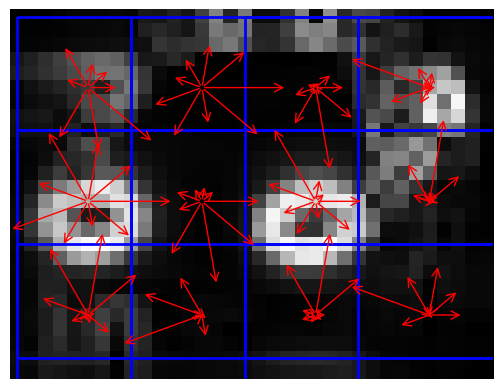

In [3]:
from data_handling import split_into_blocks

from matplotlib import patches

def gradient_patch(patch, bin_size=9, normalize=False):
    # max_angle = 180
    max_angle = 360
    #TODO check if representing 360 deg is fine
    bin_delta = (int)(max_angle / bin_size)
    ranges = np.arange(0, max_angle, bin_delta)
    bins = [(x, x + bin_delta) for x in ranges]
    mag, ang = patch
    gradient = np.zeros(bin_size)

    for angle, magnitude in zip(ang.flatten(), mag.flatten()):
        #corner cases
        if angle == max_angle:
            gradient[0] += magnitude
        elif angle % bin_delta == 0:
            gradient[(int)(angle / bin_delta)] += magnitude

        for bin_range in bins:
            if angle > bin_range[0] and angle < bin_range[1]:
                delta_left = angle - bin_range[0]
                delta_right = bin_range[1] - angle
                bin_left = delta_left / bin_delta * magnitude
                bin_right = delta_right / bin_delta * magnitude
                gradient[(int)(bin_range[0] / bin_delta)] += bin_left
                if angle < max_angle - bin_delta:
                    gradient[(int)(bin_range[1] / bin_delta)] += bin_right
                else: #another corner case
                    gradient[0] += bin_right
    
    if normalize and gradient.max() != 0:
        gradient *= patch.shape[1]/gradient.max()*.75

    return gradient

def histogram_of_oriented_gradients(magnitudes, angles, patch_size=(8,8), normalize=False):

    def _adapt_angle(angle):
        # return angle + 180 if angle < 0 else angle - 180 if angle > 180 else angle
        return angle + 180

    _angles = np.vectorize(_adapt_angle)(angles)
    # _magnitudes = magnitudes / magnitudes.sum(axis=1)[:, np.newaxis]
    _magnitudes = magnitudes
    mag_blocks = split_into_blocks(_magnitudes, patch_size)
    ang_blocks = split_into_blocks(_angles, patch_size)
    patches = np.empty((mag_blocks.shape[0], 2, mag_blocks.shape[1], mag_blocks.shape[2]))
    for index in range(0, len(mag_blocks)):
        patches[index][0] = mag_blocks[index]
        patches[index][1] = ang_blocks[index]

    return np.array([gradient_patch(patch, normalize=normalize) for patch in patches])

patch_shape = (8,8)

hog = histogram_of_oriented_gradients(magnitude, angle, patch_shape, normalize=True)

fig, ax = plt.subplots()
ax.imshow(magnitude, cmap='gray')
ax.axis('off')

def draw_oriented_gradient(ax, i, j, patch_len, bin_index, bin_val, bin_delta):
    draw_arrow(ax, 
                j * patch_len + (patch_len / 2) + 1,
                i * patch_len + (patch_len / 2) + 1,
                bin_index * bin_delta, bin_val)
            
    rect = patches.Rectangle((j * patch_len, i * patch_len), 
                                (j + 1) * patch_len,
                                (i + 1) * patch_len, 
                                linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)

for i in range(0, (int)(magnitude.shape[0]/patch_shape[0])):
    for j in range(0, (int)(magnitude.shape[1]/patch_shape[1])):
        for index, bin_val in enumerate(hog[j * (int)(magnitude.shape[0]/patch_shape[0]) + i]):
            draw_oriented_gradient(ax, i, j, patch_shape[0], index, bin_val, 360/9)
            # draw_oriented_gradient(ax, i, j, patch_shape[0], index, bin_val, 180/9)


Input image shape (1080, 1920)
Level 0 got 120 subsamples
Level 1 got 28 subsamples
Level 2 got 6 subsamples
Level 3 got 1 subsamples
Got total of 155 subsamples


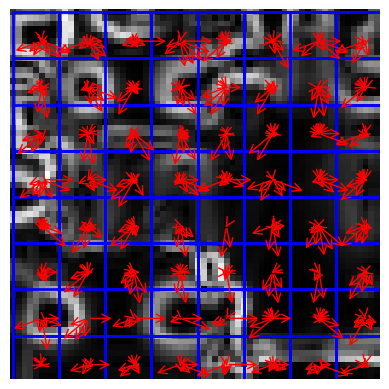

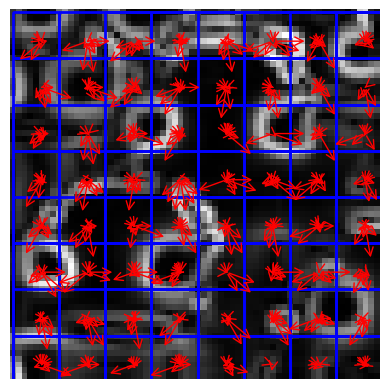

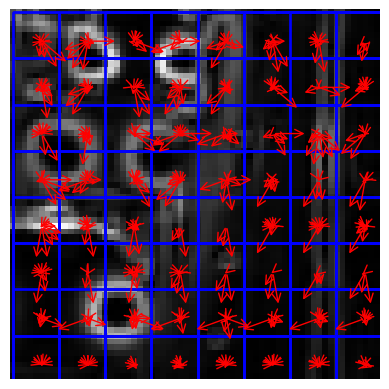

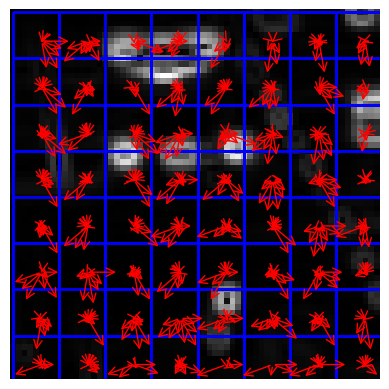

In [7]:
from hog import histogram_of_oriented_gradients
from illustrate import draw_oriented_gradient
from data_handling import feature_stack
from representation import Pyramid

detection_shape = (64, 64)
patch_shape = (8,8)

print(f'Input image shape {grayscale_image.shape}')

representation = Pyramid(levels = 4, filter = None)
samples = feature_stack(grayscale_image, representation, detection_shape)
print(f'Got total of {len(samples)} subsamples')

num_displayed_samples = 4
start_index = 50
sample_count = 1

image_filter = Sobel()
for sample in samples[start_index:]:
    data, position = sample
    _mag, _ang = image_filter.apply(data)
    hog = histogram_of_oriented_gradients(_mag, _ang, patch_shape, normalize=True)

    # plot_image(data)
    fig, ax = plt.subplots()
    ax.imshow(_mag, cmap='gray')
    ax.axis('off')
    for i in range(0, (int)(detection_shape[0]/patch_shape[0])):
        for j in range(0, (int)(detection_shape[1]/patch_shape[1])):
            for index, bin_val in enumerate(hog[j * (int)(detection_shape[0]/patch_shape[0]) + i]):
                # draw_oriented_gradient(ax, i, j, patch_shape[0], index, bin_val,360/9)
                draw_oriented_gradient(ax, i, j, patch_shape[0], index, bin_val,180/9)
    if sample_count == num_displayed_samples:
        break
    sample_count += 1

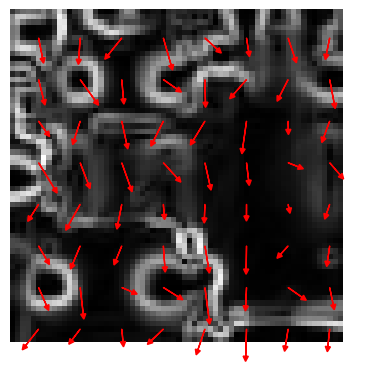

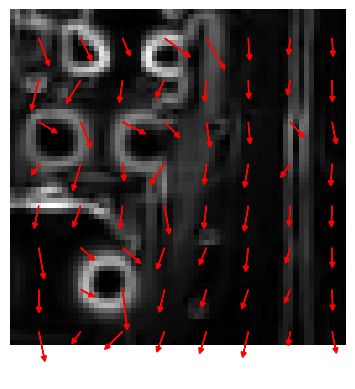

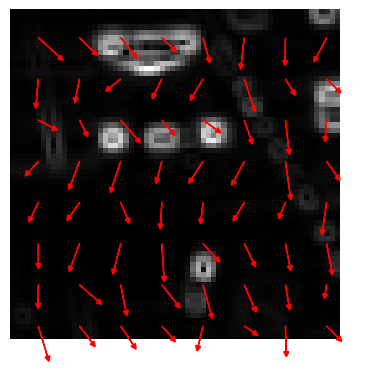

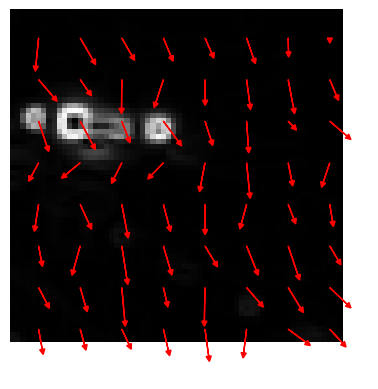

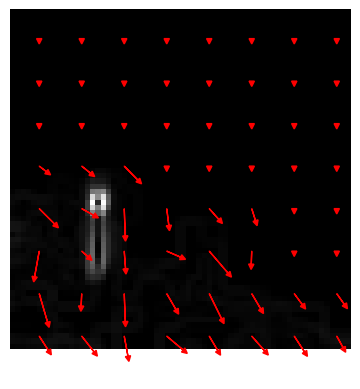

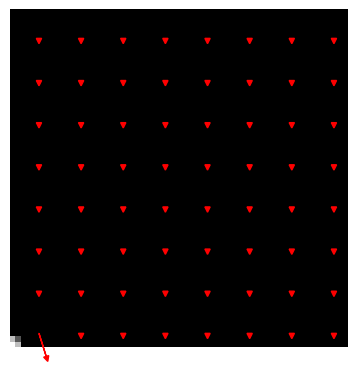

In [8]:
def polar_to_cartesian(angle, magnitude):
    angle_rad = np.radians(angle)
    x_component = magnitude * np.cos(angle_rad)
    y_component = magnitude * np.sin(angle_rad)
    return x_component, y_component

def sum_directions(directions):
    vectors = [polar_to_cartesian(angle % 360, magnitude) for angle, magnitude in directions]
    result_vector = np.sum(vectors, axis=0)
    magnitude = np.linalg.norm(result_vector)
    angle = np.degrees(np.arctan2(result_vector[1], result_vector[0])) % 360
    # angle = np.degrees(np.arctan2(result_vector[1], result_vector[0])) % 180
    return magnitude, angle

def draw_vector(ax, x, y, dx, dy, color='blue'):
    ax.arrow(x, y, dx, dy, head_width=1, head_length=1, fc=color, ec=color)

test_samples = [samples[50],samples[52],samples[53],samples[56],samples[58],samples[59]]

image_filter = Sobel()
for sample in test_samples:
    data, position = sample
    _mag, _ang = image_filter.apply(data)
    hog = histogram_of_oriented_gradients(_mag, _ang, patch_shape, normalize=True)

    # plot_image(data)
    fig, ax = plt.subplots()
    ax.imshow(_mag, cmap='gray')
    ax.axis('off')
    for i in range(0, (int)(detection_shape[0]/patch_shape[0])):
        for j in range(0, (int)(detection_shape[1]/patch_shape[1])):
            directions = hog[j * (int)(detection_shape[0]/patch_shape[0]) + i]
            # polar = np.arange(0,360 + 40,40)
            polar = np.arange(0,180 + 20,20)
            resultant_magnitude, resultant_angle = sum_directions(zip(polar,directions))
            resultant_magnitude/=4
            for a, m in zip(polar,directions):
                dx, dy = polar_to_cartesian(a, m)
                # draw_vector(ax, 
                #             i * patch_shape[0] + (patch_shape[0] / 2) + 1,
                #             j * patch_shape[0] + (patch_shape[0] / 2) + 1,
                #             dx, dy, color='lightblue')

            resultant_dx, resultant_dy = polar_to_cartesian(resultant_angle, resultant_magnitude)
            draw_vector(ax, 
                        i * patch_shape[0] + (patch_shape[0] / 2) + 1,
                        j * patch_shape[0] + (patch_shape[0] / 2) + 1,
                        resultant_dx, resultant_dy, color='red')
